
1. But de l'exercice : Votre objectif est de créer un simple réseau de neurones convolutifs (CNN) pour la classification d'images. Pour cet exercice, vous pouvez utiliser l'ensemble de données CIFAR-10 qui est une collection d'images de 10 classes différentes.
2. Tâches :
    - Faites un train de ce model sur GPU
    - Modifier le CNN en ajoutant des couches suplémentaires
    - Crée une séquence Conv2d --> BatchNorm2d --> ReLU
    - Réalisez plusieurs entraînements avec des couches et des paramètres différents, puis comparez les résultats en utilisant `from sklearn.metrics import classification_report`.

## Bonus

### GoogLeNet: Un Aperçu Historique
GoogLeNet est un modèle de réseau neuronal convolutif profond qui a été proposé par des chercheurs de Google, d'où son nom. Le modèle a été introduit pour la première fois en 2014 dans le papier de recherche intitulé "[Going Deeper with Convolutions](https://arxiv.org/abs/1409.4842)", et a remporté le défi de la classification visuelle d'ImageNet (ILSVRC) cette même année.
Le modèle est plus particulièrement célèbre pour deux de ses caractéristiques uniques :


### Inception Module :
L'Inception Module est une micro-architecture novatrice (ou un "bloc de construction") pour les CNN. Il est basé sur une philosophie intelligente de conception de réseau qui interroge "à quoi ressemblerait une bonne solution locale" pour la conception de réseau.

Le Module Inception a introduit l'idée d'avoir plusieurs opérations de convolution de différentes tailles (1x1, 3x3, 5x5) en parallèle dans un même niveau de l'architecture, permettant au CNN d'apprendre des caractéristiques à différentes échelles. Cela a également amené à une plus grande efficacité en termes de calcul.

![inception](../asset/inception.png)

### Profondeur du réseau :
GoogLeNet a été l'un des premiers réseaux neuronaux profonds avec 22 couches de profondeur. En utilisant l'Inception Module et une grande profondeur, GoogLeNet a pu atteindre des performances élevées sur diverses tâches de vision par ordinateur, y compris la classification des images.
Il convient de noter que même si GoogLeNet a lancé l'idée originale du Module Inception, de nombreuses variantes et améliorations ont été introduites depuis, telles que Inception-v2, Inception-v3 et Inception-v4, chacune améliorant les performances et l'efficacité de la précédente.

![googlenet architecture](../asset/googlenet_architecture.png)

Pour l'anecdote, ce modèle compte 25 millions de paramètres, en 2014 il était assser difficile pour l'utilisateur classique de le train  Maintenant, un LLM classique comme Mistral comporte 7 milliards de paramètres, ou comme ChatGPT-3.5 qui en compte 175 milliards !!!

## Objectif

Réalisez une version miniature de la couche Inception, puis ajoutez-la à votre réseau actuel.

![mini](../asset/inception_mini.png)

In [1]:
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.nn.functional import relu

batch_size = 4

# Load and normalize the CIFAR10 training and test datasets
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [2]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

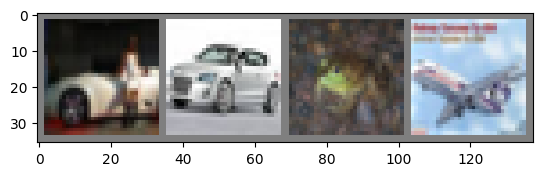

automobile automobile frog  airplane
Shape torch.Size([4, 3, 32, 32])


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # unnormalize
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Batch, color chan, width, height
print("Shape", images.shape)

In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
# Define a simple CNN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(relu(self.conv1(x)))
        x = self.pool(relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = relu(self.fc1(x))
        x = relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Create a Net
net = Net()

# Define Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

net.to(device)

# Train the network
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.169
[1,  4000] loss: 1.803
[1,  6000] loss: 1.664
[1,  8000] loss: 1.573
[1, 10000] loss: 1.515
[1, 12000] loss: 1.465
[2,  2000] loss: 1.385
[2,  4000] loss: 1.370
[2,  6000] loss: 1.324
[2,  8000] loss: 1.314
[2, 10000] loss: 1.287
[2, 12000] loss: 1.295
Finished Training


In [6]:
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

# Set the model in evaluation mode
net.eval()

true_labels = []
predictions = []

# Disabling gradient calculation
with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data

        # Send inputs to the device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = net(images)
        predicted = torch.argmax(outputs.data, 1)
        # Store results
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

# Generate classification report
report = classification_report(true_labels, predictions)
print(report)

  0%|          | 0/2500 [00:06<?, ?it/s]

              precision    recall  f1-score   support

           0       0.56      0.61      0.58      1000
           1       0.74      0.56      0.64      1000
           2       0.44      0.41      0.42      1000
           3       0.43      0.26      0.33      1000
           4       0.47      0.46      0.46      1000
           5       0.44      0.59      0.50      1000
           6       0.58      0.67      0.62      1000
           7       0.61      0.64      0.62      1000
           8       0.65      0.58      0.62      1000
           9       0.59      0.67      0.63      1000

    accuracy                           0.55     10000
   macro avg       0.55      0.55      0.54     10000
weighted avg       0.55      0.55      0.54     10000
